# EmotionX
Best model for Friends dataset <br>
Author: Andrew Nguyen <br>
Date: 9/6/2019 

Summary: <br>
Using the target utterance only (utterance2) <br>
-> feature selection using TFIDF <br>
-> one hot encoding <br>
-> linearSVM

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import sys
sys.path
sys.path.append('../')

# custom functs
from src.features import build_features
from src.visualization.visualize import plot_confusion_matrix
from src.utils.utils import get_project_root

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

import random
from collections import Counter

from nltk import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Binarizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.multiclass import unique_labels

## Prepare data

In [4]:
ROOT_PATH = get_project_root()
TRAIN_PATH = ROOT_PATH / "data/raw/EmotionX2018/friends.train.json"
DEV_PATH = ROOT_PATH / "data/raw/EmotionX2018/friends.dev.json"
TEST_PATH = ROOT_PATH / "data/raw/EmotionX2018/friends.test.json"

df_train = build_features.to_df(TRAIN_PATH)
df_dev = build_features.to_df(DEV_PATH)
df_test = build_features.to_df(TEST_PATH)

In [5]:
df_train["split"] = "train"
df_dev["split"] = "dev"
df_test["split"] = "test"

In [6]:
# concat df
df = pd.concat([df_train, df_dev, df_test], ignore_index=True)
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split
0,4100000,0,NaN,neutral,neutral,NaN,also I was the point person on my company's tr...,You must've had your hands full.,train
1,5000000,0,neutral,neutral,neutral,also I was the point person on my company's tr...,You must've had your hands full.,That I did. That I did.,train
2,5000000,0,neutral,neutral,neutral,You must've had your hands full.,That I did. That I did.,So let's talk a little bit about your duties.,train
3,5000000,0,neutral,neutral,surprise,That I did. That I did.,So let's talk a little bit about your duties.,My duties? All right.,train
4,2000030,0,neutral,surprise,neutral,So let's talk a little bit about your duties.,My duties? All right.,"Now you'll be heading a whole division, so you...",train
5,5000000,0,surprise,neutral,neutral,My duties? All right.,"Now you'll be heading a whole division, so you...",I see.,train
6,3100010,0,neutral,neutral,neutral,"Now you'll be heading a whole division, so you...",I see.,But there'll be perhaps 30 people under you so...,train
7,4000100,0,neutral,neutral,neutral,I see.,But there'll be perhaps 30 people under you so...,Good to know.,train
8,4100000,0,neutral,neutral,neutral,But there'll be perhaps 30 people under you so...,Good to know.,We can go into detail,train
9,4000100,0,neutral,neutral,fear,Good to know.,We can go into detail,No don't I beg of you!,train


In [7]:
# simplify emotion labels
df = df[df.emotion2.isin(["neutral", "joy", "sadness", "anger"])]

In [8]:
df = df.reset_index(drop=True)

## Preprocess

In [9]:
# make nan utterances -> empty strings
df.utterance1 = df.utterance1.fillna("")
df.utterance3 = df.utterance3.fillna("")

In [10]:
# preappend utterance 1 + utterance 2 with number
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

def preappend(sent, num):
    words = tokenizer.tokenize(sent)
    
    # remove stop words
    stopWords = set(stopwords.words('english'))
    words = [ w for w in words if w not in stopWords]
    
    words = [ num + w for w in words]
    return words

df.utterance1 = df.utterance1.apply(lambda x: preappend(x, "1_"))
df.utterance2 = df.utterance2.apply(lambda x: preappend(x, "2_"))
df.utterance3 = df.utterance3.apply(lambda x: preappend(x, "3_"))

In [11]:
# append utt1 and utt2 arrays together
temp = df[["utterance1", "utterance2"]].values.tolist()
temp = [ t[0] + t[1] for t in temp]
df["utterance12"] = temp

## TFIDF 

In [12]:
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split,utterance12
0,4100000,0,NaN,neutral,neutral,[],"[2_also, 2_point, 2_person, 2_company's, 2_tra...","[3_must've, 3_hands, 3_full, 3_.]",train,"[2_also, 2_point, 2_person, 2_company's, 2_tra..."
1,5000000,0,neutral,neutral,neutral,"[1_also, 1_point, 1_person, 1_company's, 1_tra...","[2_must've, 2_hands, 2_full, 2_.]","[3_., 3_.]",train,"[1_also, 1_point, 1_person, 1_company's, 1_tra..."
2,5000000,0,neutral,neutral,neutral,"[1_must've, 1_hands, 1_full, 1_.]","[2_., 2_.]","[3_let's, 3_talk, 3_little, 3_bit, 3_duties, 3_.]",train,"[1_must've, 1_hands, 1_full, 1_., 2_., 2_.]"
3,5000000,0,neutral,neutral,surprise,"[1_., 1_.]","[2_let's, 2_talk, 2_little, 2_bit, 2_duties, 2_.]","[3_duties, 3_?, 3_right, 3_.]",train,"[1_., 1_., 2_let's, 2_talk, 2_little, 2_bit, 2..."
4,5000000,0,surprise,neutral,neutral,"[1_duties, 1_?, 1_right, 1_.]","[2_heading, 2_whole, 2_division, 2_,, 2_lot, 2...","[3_see, 3_.]",train,"[1_duties, 1_?, 1_right, 1_., 2_heading, 2_who..."
5,3100010,0,neutral,neutral,neutral,"[1_heading, 1_whole, 1_division, 1_,, 1_lot, 1...","[2_see, 2_.]","[3_there'll, 3_perhaps, 3_30, 3_people, 3_dump...",train,"[1_heading, 1_whole, 1_division, 1_,, 1_lot, 1..."
6,4000100,0,neutral,neutral,neutral,"[1_see, 1_.]","[2_there'll, 2_perhaps, 2_30, 2_people, 2_dump...","[3_good, 3_know, 3_.]",train,"[1_see, 1_., 2_there'll, 2_perhaps, 2_30, 2_pe..."
7,4100000,0,neutral,neutral,neutral,"[1_there'll, 1_perhaps, 1_30, 1_people, 1_dump...","[2_good, 2_know, 2_.]","[3_go, 3_detail]",train,"[1_there'll, 1_perhaps, 1_30, 1_people, 1_dump..."
8,4000100,0,neutral,neutral,fear,"[1_good, 1_know, 1_.]","[2_go, 2_detail]","[3_beg, 3_!]",train,"[1_good, 1_know, 1_., 2_go, 2_detail]"
9,4100000,0,fear,neutral,surprise,"[1_beg, 1_!]","[2_right, 2_,, 2_we'll, 2_definite, 2_answer, ...","[3_really, 3_?, 3_!]",train,"[1_beg, 1_!, 2_right, 2_,, 2_we'll, 2_definite..."


In [13]:
# get vocab
ll = df.utterance12.values.tolist()

shared_vocab = set()
for l in ll:
    shared_vocab.update(l)

In [14]:
counts_df = pd.DataFrame(columns=list(shared_vocab), index = ["anger", "joy", "neutral", "sadness"])
counts_df = counts_df.fillna(0)

## Counting the number of occurances of each token in the corpus of each class
for i, tokens in enumerate(df['utterance12']):
    for word in tokens:
        if word in shared_vocab:
            labl =  df['emotion2'][i]
            counts_df[word][labl]+=1

In [15]:
tfidf = TfidfTransformer()

X_tfidf = tfidf.fit_transform(counts_df.values).toarray()

In [16]:
word_score = []
word_emote = []
for x in zip(*X_tfidf):
    y = [('angry', x[0]), ('joy', x[1]), ('neutral', x[2]), ('sadness', x[3])]
    y = sorted(y, key=lambda x: x[1])
    word_score.append(y[3][1] - y[2][1])
    word_emote.append(y[3][0])

In [17]:
rank = list(zip(shared_vocab, word_score, word_emote))

In [19]:
rank = sorted(rank, key=lambda x:x[1], reverse=True)

In [20]:
vocab = [ w[0] for w in rank]

## Feature transform (onehot)

In [21]:
X = df.utterance2

def do_nothing(tokens):
    return tokens

#  [1000, 2500, 5000, 10000]:
half = int(len(vocab)/2)
curvocab = vocab[0:half]

freq = CountVectorizer(tokenizer=do_nothing, vocabulary=curvocab, preprocessor=None, lowercase=False)
X = freq.fit_transform(X)

onehot = Binarizer()
X = onehot.fit_transform(X.toarray())

In [22]:
len(vocab)

10821

In [23]:
len(freq.vocabulary_)

5410

##  Train test split

In [24]:
# # X as is from above
y = df.emotion2
split = df.split

In [25]:
trainIdx = split[split.isin(["train", "dev"])].index.tolist()
testIdx = split[split == "test"].index.tolist()

X_train = [X[i] for i in trainIdx]
X_test = [X[i] for i in testIdx]
y_train = [y[i] for i in trainIdx]
y_test = [y[i] for i in testIdx]

## Fit and eval on train data

In [26]:
clf = LinearSVC(random_state=0)

In [27]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [28]:
# predict
y_pred = clf.predict(X_test)

## Eval predictions

Confusion matrix, without normalization
[[  54   65   41    1]
 [  12  215   74    3]
 [  21   77 1162   27]
 [   4    6   54   21]]


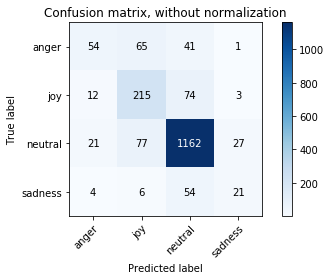

In [29]:
# np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.33540373 0.40372671 0.25465839 0.00621118]
 [0.03947368 0.70723684 0.24342105 0.00986842]
 [0.01631702 0.05982906 0.9028749  0.02097902]
 [0.04705882 0.07058824 0.63529412 0.24705882]]


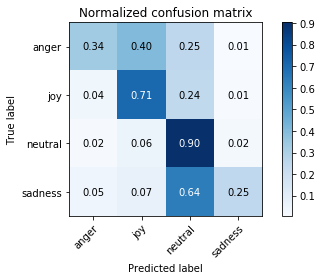

In [30]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.59      0.34      0.43       161
         joy       0.59      0.71      0.64       304
     neutral       0.87      0.90      0.89      1287
     sadness       0.40      0.25      0.31        85

   micro avg       0.79      0.79      0.79      1837
   macro avg       0.62      0.55      0.57      1837
weighted avg       0.78      0.79      0.78      1837



## Micro F1

In [32]:
print("{:.4f}".format(f1_score(y_test, y_pred, average='micro')))

0.7904


## Fit and predict for eval

In [33]:
clf = LinearSVC(random_state=0)
clf.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [34]:
ROOT_PATH = get_project_root()
EVAL_PATH = ROOT_PATH / "data/raw/eval/friends_eval.json"
df_eval = build_features.to_df(EVAL_PATH)

def transform(df):
    # make nan utterances -> empty strings
    df.utterance1 = df.utterance1.fillna("")

    # preappend utterance 1 + utterance 2 with number
    tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

    def preappend(sent, num):
        words = tokenizer.tokenize(sent)

        # remove stop words
        stopWords = set(stopwords.words('english'))
        words = [ w for w in words if w not in stopWords]

        words = [ num + w for w in words]
        return words

    df.utterance1 = df.utterance1.apply(lambda x: preappend(x, "1_"))
    df.utterance2 = df.utterance2.apply(lambda x: preappend(x, "2_"))
    
    # append utt1 and utt2 arrays together
    temp = df[["utterance1", "utterance2"]].values.tolist()
    temp = [ t[0] + t[1] for t in temp]
    df["utterance12"] = temp
    
    return df

df_evall = transform(df_eval)

In [35]:
def x(df,vocab):

    X = df.utterance2

    def do_nothing(tokens):
        return tokens

    #  [1000, 2500, 5000, 10000]:
    half = int(len(vocab)/2)
    curvocab = vocab[0:half]

    freq = CountVectorizer(tokenizer=do_nothing, vocabulary=curvocab, preprocessor=None, lowercase=False)
    X = freq.fit_transform(X)

    onehot = Binarizer()
    X = onehot.fit_transform(X.toarray())   

#     y = df.emotion2
    return X

X = x(df_evall, vocab)

In [36]:
y_pred = clf.predict(X)

In [37]:
# generate output file
EVAL_PATH = ROOT_PATH / "data/raw/eval/friends_eval.json"
file = EVAL_PATH
if file:
    with open(file, 'r') as f:
        datastore = json.load(f)    

In [38]:
iypred = 0

for i in range(len(datastore)):
    for j in range(len(datastore[i])):
        datastore[i][j]["emotion"] = y_pred[iypred]
        iypred += 1

In [39]:
mydets = {
    "name": "Andrew Nguyen",
    "email": "andrew.nguyen03@adelaide.edu.au"
}

out = [mydets, datastore]

In [40]:
OUT_PATH = ROOT_PATH / "data/processed/friends.submission.json"
filename = OUT_PATH
if filename:
    # Writing JSON data
    with open(filename, 'w') as f:
        json.dump(out, f)

In [41]:
df_eval.shape

(3296, 5)

In [42]:
len(y_pred)

3296